### En este notebook vamos a probar diferentes clasificadores con los datos que hemos creado anteriormente. Se tendrá en cuanta para decidir el mejor tanto la precision como el tiempo de convergencia de la funcion de coste etc.

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics

Leemos los datos de train/test y creamos Xtrain/test y ytrain/test

In [ ]:
dataTrain = np.load('train_img_features_non_processed.npy')
Xtrain = dataTrain[:,:-1]
ytrain = dataTrain[:,-1]

dataTest = np.load('test_img_features_non_processed.npy')
Xtest = dataTest[:,:-1]
ytest = dataTest[:,-1]

### Regresion logistica

Probamos el clasificador de regresión logistica con los datos de test

En el caso de la regresion logistica hemos tenido que aumentar el numero de iteraciones a 200 frente a las 100 que tiene por defecto para que hubiera covergencia debido al alto numero de caracteristicas de los datos.

In [ ]:
from sklearn.linear_model import LogisticRegression
clfLogRegr = LogisticRegression(random_state=0,max_iter=400).fit(Xtrain, ytrain)

clfLogRegr.score(Xtest,ytest)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(Xtrain, ytrain)
clf.score(Xtest,ytest)

Probamos tambien Naive Bayes multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(Xtrain,ytrain)
clf.score(Xtest,ytest)

### SVMs

In [ ]:
from sklearn import svm
clf_SVM = svm.SVC()
clf_SVM.fit(Xtrain, ytrain)
clf_SVM.score(Xtest,ytest)

### Probar un conjunto de clasificadores usando SKlearn

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
import time
import matplotlib.pyplot as plt

nombresDatasets = ['non_processed','processed']
datasets = {}

for nombre in nombresDatasets:
    pathTrain = 'train_img_features_'+nombre+'.npy'
    pathTest = 'test_img_features_'+nombre+'.npy'
    
    dataTrain = np.load(pathTrain)
    Xtrain = dataTrain[:,:-1]
    ytrain = dataTrain[:,-1]
    
    dataTest = np.load(pathTest)
    Xtest = dataTest[:,:-1]
    ytest = dataTest[:,-1]
    
    datasets[nombre] = (Xtrain,ytrain,Xtest,ytest)

#Definimos un conjunto de clasificadores
classifiers = [
    SVC(),
    LogisticRegression(random_state=0,max_iter=400),
    GaussianNB(),
    DecisionTreeClassifier(),
    MLPClassifier()]

clf_names = ['SVM', 'Regr Logistica', 'NB Gaussiano','Decision Tree','Red Neuronal']

score_list = []
time_list = []
aux_params = []
Best_score = np.NINF

#Definimos un diccionario con diccionarios para los parametergrids de GridSearchCV
parameters_dict = {'SVM':{'kernel':('linear', 'rbf'), 'C':[1, 10],'gamma':[0.1,0.001]},
                    'Regr Logistica':{'C': [0.01, 1, 10, 1000] },
                    'NB Gaussiano':{'var_smoothing': np.logspace(0,-9, num=10)},
                    'Decision Tree':{'min_samples_split': [2, 3, 4],
                                     'criterion': ['gini', 'entropy']},
                    'Red Neuronal':{'activation': ['tanh', 'relu'],
                                    'solver': ['sgd', 'adam']}
                  }
#Probamos los clasificadores
for i,(clf_aux,clf_name) in enumerate(zip(classifiers,clf_names)):
    for j,dataset in enumerate(nombresDatasets):
        #Clonamos el clasificador ya que lo vamos a usar 2 veces
        clf = clone(clf_aux)
        
        #Extraemos los datos de train y test
        print('Entrenando {} con {}'.format(dataset,clf_name))
        (Xtrain,ytrain,Xtest,ytest) = datasets[dataset]
        
        #Calculamos los parametros optimos con GridSearchCV
        t0 = time.time()
        clf = GridSearchCV(clf,parameters_dict[clf_name],cv = 2,n_jobs=10)
        clf.fit(Xtrain,ytrain)
        t1 = time.time()
        time_list.append(t1-t0)
        
        #Calculamos la precision, la guardamos y vemos si hemos mejorado
        score = round(clf.score(Xtest,ytest)*100,2)
        score_list.append(score)
        aux_params.append(clf.best_params_)
        if score >= Best_score:
            Best_score = score
            Best_dataset = dataset
            Best_clf = clf
            nBest_clf = i*2 +j
        print('Time elapsed on fit: {}\n'.format(round(t1-t0,2)))
print('Total time elapsed {}'.format(round(np.sum(time_list),2)))

Entrenando non_processed con SVM
Time elapsed on fit: 27.42

Entrenando processed con SVM
Time elapsed on fit: 26.49

Entrenando non_processed con Regr Logistica
Time elapsed on fit: 43.1

Entrenando processed con Regr Logistica
Time elapsed on fit: 44.97

Entrenando non_processed con NB Gaussiano
Time elapsed on fit: 14.61

Entrenando processed con NB Gaussiano
Time elapsed on fit: 14.59

Entrenando non_processed con Decision Tree
Time elapsed on fit: 32.4

Entrenando processed con Decision Tree
Time elapsed on fit: 24.97

Entrenando non_processed con Red Neuronal
Time elapsed on fit: 82.91

Entrenando processed con Red Neuronal
Time elapsed on fit: 87.95

Total time elapsed 399.42


[93.22, 92.46, 93.97, 94.22, 86.93, 88.19, 70.1, 65.33, 93.22, 92.46]
3


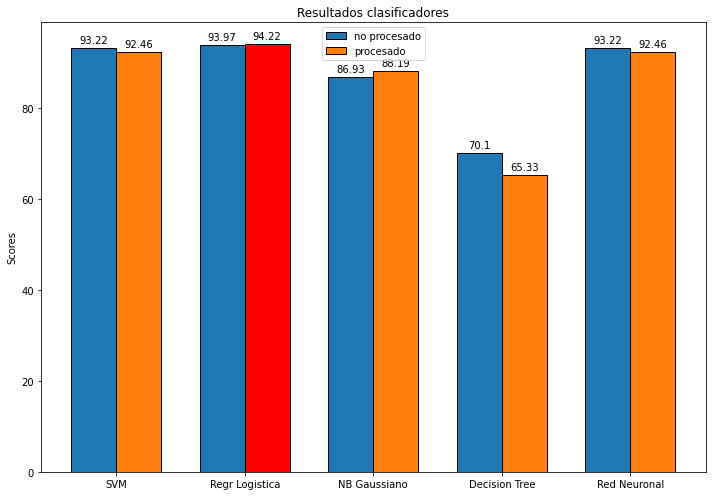

El mejor clasificador ha sido: Regr Logistica en processed
La mejor puntuacion ha sido 94.22 en Regr Logistica


In [12]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = np.arange(len(clf_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,7))
rects1 = ax.bar(x - width/2, score_list[::2], width, label='no procesado',edgecolor='k')
rects2 = ax.bar(x + width/2, score_list[1::2], width, label='procesado',edgecolor='k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Resultados clasificadores')
ax.set_xticks(x)
ax.set_xticklabels(clf_names)
ax.legend()

autolabel(rects1)
autolabel(rects2)
print(score_list)
print(nBest_clf)
i_clf = int(nBest_clf/2)
if nBest_clf % 2 == 0:
    rects1[i_clf].set_color('r')
    rects1[i_clf].set_edgecolor('k')
else:
    if score_list[i_clf] == score_list[i_clf-1]:
        rects1[i_clf].set_color('r')
        rects2[i_clf].set_color('r')
        rects1[i_clf].set_edgecolor('k')
        rects2[i_clf].set_edgecolor('k')
    else:
        rects2[i_clf].set_color('r')
        rects2[i_clf].set_edgecolor('k')
fig.tight_layout()

plt.show()

print('El mejor clasificador ha sido: {} en {}'.format(clf_names[i_clf],Best_dataset))
print('La mejor puntuacion ha sido {} en {}'.format(Best_score,clf_names[i_clf]))

In [16]:
#Graficas de tiempo

In [15]:
aux_params
import pickle
# save the classifier
with open('signclassifier.pkl', 'wb') as f:
    pickle.dump(Best_clf, f)  